# Week 3 Mini Project

### Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opendatasets

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import os
import pandas as pd
import pickle
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, ReLU
from keras.initializers import Constant
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# download data
od.download(
    "https://www.kaggle.com/competitions/histopathologic-cancer-detection/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: juliahoglund
Your Kaggle Key: ··········


100%|██████████| 6.31G/6.31G [01:01<00:00, 110MB/s] 



Extracting archive ./histopathologic-cancer-detection/histopathologic-cancer-detection.zip to ./histopathologic-cancer-detection


## Introduction

The purpose of this project is build a neural network that identifies metastatic cancer in small image patches taken from larger digital pathology scans. The images are comprised of 96x96 pixels in the RGB color scale, so the size of the data is 96x96x3. A positive label (1) is indicated by the center of a 32x32 pixel reagion that contains at least one pixel of tumor tissue.

### Data Ingestion

We will start by reading in the training labels. This csv has 220,025 images each with a label that indicates if the cells in the image are considered cancerous (1) or not (0). We will also read in the test directory and create a test dataframe for creating predictions from our best model.

In [5]:
df = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
print(df.shape)
df.head()

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
test_dir = os.listdir('histopathologic-cancer-detection/test/')
df_test = pd.DataFrame(test_dir)
df_test.columns = ['id']
df_test.head()

,id
0,ad8e934f62922e9093790b7e86d85afa10b192f7.tif
1,aa13203d7a7c4ab39d40638d9dcc04ca565ce447.tif
2,1dacd04201a902090526c452b00021ad23e3ddc1.tif
3,94ef9402a7895afdcf9d91fae3f0d63712d3a74e.tif
4,2c0dd504578ca355a708a67854af1d6ddf17e707.tif


## Exploratory Data Analysis

We will start by inspecting how many positive and negative labels we have. We can see that about 40% of the labels are positive (1) and 60% of the labels are negative (0). This is slightly unbalanced.

Percentage of Positive Labels:  40.503124644926714


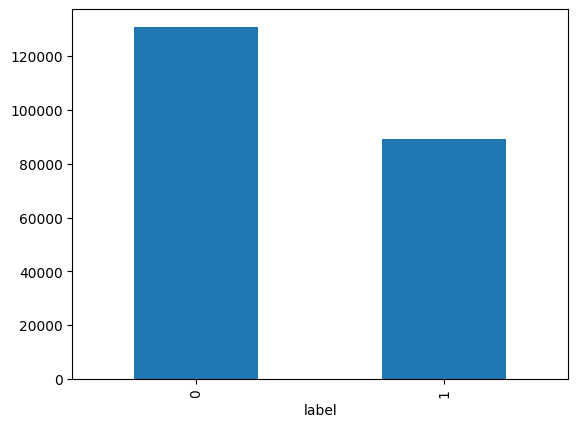

In [7]:
df['label'].value_counts().plot(kind="bar")
print("Percentage of Positive Labels: ", 100* len(df[df['label']==1])/len(df))

In order balance out our dataset and decrease bias for our CNN, we will take a random sample of 50,000 images from each label and use that for our training data.

<Axes: xlabel='label'>

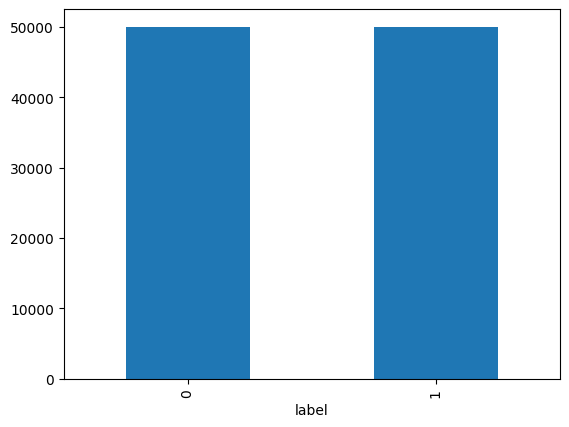

In [8]:
df_0 = df[df['label']==0].sample(50000,random_state=1)
df_1 = df[df['label']==1].sample(50000,random_state=1)

df = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

df['label'].value_counts().plot(kind="bar")

Next, we will visualize a sample of our images and see what images are labelled as positive and which are labelled as negative.

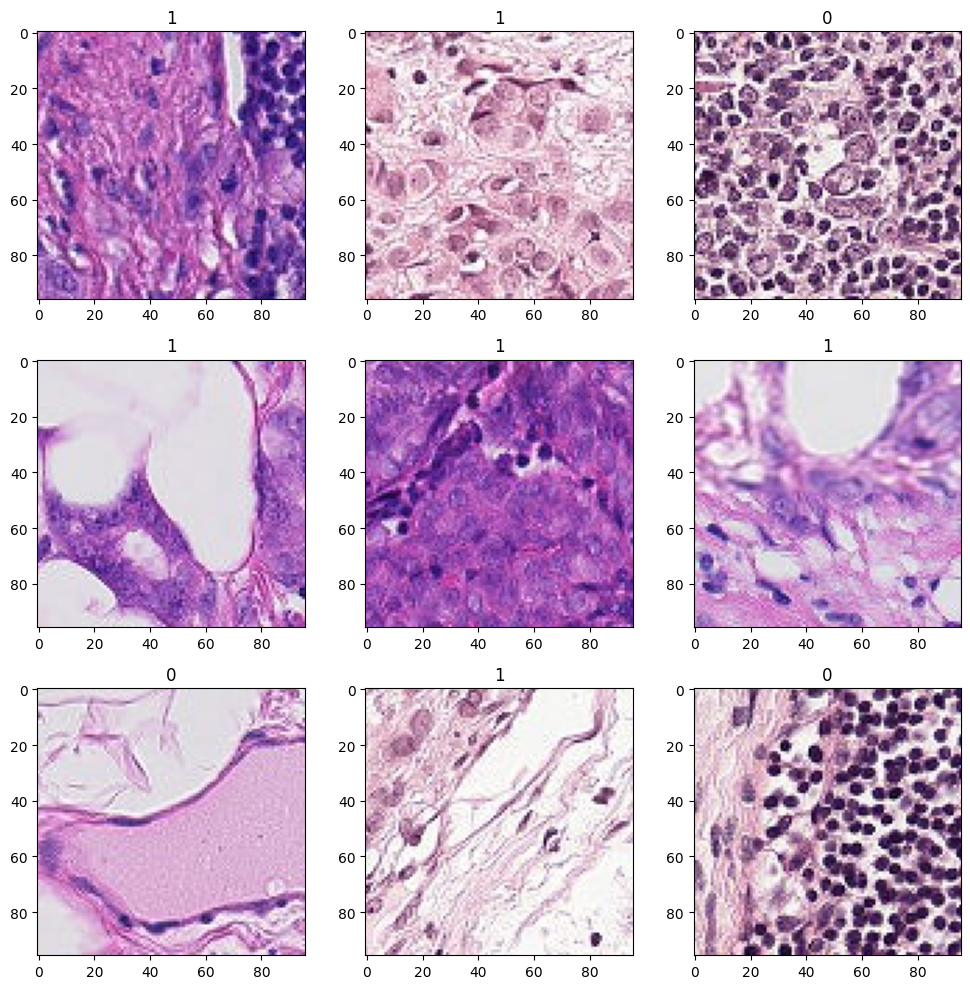

In [9]:
np.random.seed(1)
sample = np.random.choice(df.index,9)

fig, ax = plt.subplots(3, 3,figsize=(10,10))

for i in range(0, sample.shape[0]):
  ax = plt.subplot(3, 3, i+1)
  img = mpimg.imread(f'histopathologic-cancer-detection/train/{df.iloc[sample[i],0]}.tif')
  ax.imshow(img)
  ax.set_title(df.iloc[sample[i],1])

plt.tight_layout()
plt.show()

Based on this EDA, we have ensured that we have a balanced dataset for our model to train on. For a plan of analysis, we will test 3 different CNN architectures and check the accuracy and auc of each model to determine the best performing one.

## Model Architecture

In order to find the best CNN architecture for this problem, we will tune hyperparameters on the number of layers in the model as well as the learning rate. We will do an 80% training set split to a 20% validation set split.

In [10]:
y = df['label']
df_train, df_valid = train_test_split(df, test_size=0.20, random_state=1, stratify=y)

print(df_train.shape)
print(df_valid.shape)

(80000, 2)
(20000, 2)


We will set up a train, validation, and test generator and confirm the correct number of images in each set.

In [11]:
df_train['id'] = df_train['id']+'.tif'
df_valid['id'] = df_valid['id']+'.tif'

df_train['label'] = df_train['label'].astype(str)
df_valid['label'] = df_valid['label'].astype(str)

imggen = ImageDataGenerator(rescale=1/255)

train_gen = imggen.flow_from_dataframe(dataframe=df_train,
                                       directory="histopathologic-cancer-detection/train/",
                                       x_col="id",
                                       y_col="label",
                                       target_size=(96,96),
                                       batch_size=32,
                                       seed=1,
                                       shuffle=True,
                                       class_mode="categorical")

valid_gen = imggen.flow_from_dataframe(dataframe=df_valid,
                                       directory="histopathologic-cancer-detection/train/",
                                       x_col="id",
                                       y_col="label",
                                       target_size=(96,96),
                                       batch_size=32,
                                       seed=1,
                                       shuffle=True,
                                       class_mode="categorical")

test_gen = imggen.flow_from_dataframe(dataframe=df_test,
                                      directory="histopathologic-cancer-detection/test/",
                                      x_col="id",
                                      target_size=(96,96),
                                      batch_size=32,
                                      seed=1,
                                      shuffle=False,
                                      class_mode=None)

Found 80000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


In [12]:
print(train_gen.image_shape)

(96, 96, 3)


### Model Description

The models we will test will have an increasing number of convolutional layers starting with 2 and going up to 4 layers. Each layer will also have an increasing number of filters starting with 32 and going up to 256 for the 4-layer model. We will also use the ReLU activation function which introduces non-linearity into the model. Then we will add a pooling component which will reduce the dimensionality of the feature map and ensure that variations in the input do not skew the results. After the convolutional layers, there will be a flatten layer and dense layer that creates a fully connected layer. The dropout layer will then reduce overfitting by dropping neurons from the layer. The output layer is another dense layer using the sigmoid activation function, which is good for binary classification. The model is then compiled using the adam optimizer and a binary cross entropy loss function.

### Hyperparamters

The hyperparameters tuned for this project will be the number of layers in the model and the learning rate. There will be 3 models created using 2, 3, and 4 layers. The learning rate will be tuned during the model fitting stage using the ReduceLROnPlateau tool. The learning rate will start out at 0.001 and as the model is fit, the learning rate will lower by 0.1 every time a plateau is reached. Thus the model can find the most approriate learning rate.

### Model 1

In [11]:
model1 = Sequential()

# Convolutional Layer 1
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense Layers
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(2, activation='sigmoid'))

model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 92, 92, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 44, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 42, 42, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28224)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,612,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,678,626 (14.03 MB)

 Trainable params: 3,678,626 (14.03 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
train_steps = int(np.ceil(len(df_train) / 32))
val_steps = int(np.ceil(len(df_valid) / 32))

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
rd = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
history1 = model1.fit(train_gen,
                      validation_data=valid_gen,
                      validation_steps=val_steps,
                      epochs=12,
                      steps_per_epoch=train_steps,
                      callbacks=[rd, es])

Epoch 1/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 99s 40ms/step - accuracy: 0.8561 - loss: 0.3397 - val_accuracy: 0.8695 - val_loss: 0.3072 - learning_rate: 0.0010
Epoch 2/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8737 - loss: 0.3012
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 93s 37ms/step - accuracy: 0.8737 - loss: 0.3012 - val_accuracy: 0.8724 - val_loss: 0.3081 - learning_rate: 0.0010
Epoch 3/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 144s 38ms/step - accuracy: 0.9014 - loss: 0.2404 - val_accuracy: 0.8853 - val_loss: 0.2768 - learning_rate: 1.0000e-04
Epoch 4/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9097 - loss: 0.2190
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 144s 39ms/step - accuracy: 0.9097 - loss: 0.2190 - val_accuracy: 0.8839 - val_loss: 0.2786 - learning_rate: 1.0000e-04
Epoch 5/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 139s 38ms/step

In [34]:
with open('/content/drive/MyDrive/Colab Notebooks/model1_history.pkl', 'wb') as f:
    pickle.dump(history1.history, f)

with open('/content/drive/MyDrive/Colab Notebooks/model1.pkl', 'wb') as file:
    pickle.dump(model1, file)

model1.save('/content/drive/MyDrive/Colab Notebooks/model1.keras')

### Model 2

In [35]:
model2 = Sequential()

# Convolutional Layer 1
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense Layers
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='sigmoid'))

model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 92, 92, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 44, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 42, 42, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 17, 17, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,482,850 (17.10 MB)

 Trainable params: 4,482,850 (17.10 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
train_steps = int(np.ceil(len(df_train) / 32))
val_steps = int(np.ceil(len(df_valid) / 32))

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
rd = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
history2 = model2.fit(train_gen,
                      validation_data=valid_gen,
                      validation_steps=val_steps,
                      epochs=12,
                      steps_per_epoch=train_steps,
                      callbacks=[rd, es])

Epoch 1/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 102s 39ms/step - accuracy: 0.7385 - loss: 0.5260 - val_accuracy: 0.8150 - val_loss: 0.4089 - learning_rate: 0.0010
Epoch 2/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 138s 38ms/step - accuracy: 0.8357 - loss: 0.3782 - val_accuracy: 0.8637 - val_loss: 0.3121 - learning_rate: 0.0010
Epoch 3/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 95s 38ms/step - accuracy: 0.8618 - loss: 0.3225 - val_accuracy: 0.8744 - val_loss: 0.2908 - learning_rate: 0.0010
Epoch 4/12
2499/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8771 - loss: 0.2962
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 142s 38ms/step - accuracy: 0.8771 - loss: 0.2962 - val_accuracy: 0.8821 - val_loss: 0.2995 - learning_rate: 0.0010
Epoch 5/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 141s 38ms/step - accuracy: 0.9050 - loss: 0.2380 - val_accuracy: 0.9018 - val_loss: 0.2396 - learning_rate: 1.0000e-04
Epoch 6/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 96s 38ms/step -

In [37]:
with open('/content/drive/MyDrive/Colab Notebooks/model2_history.pkl', 'wb') as f:
    pickle.dump(history2.history, f)

with open('/content/drive/MyDrive/Colab Notebooks/model2.pkl', 'wb') as file:
    pickle.dump(model2, file)

model2.save('/content/drive/MyDrive/Colab Notebooks/model2.keras')

### Model 3

In [38]:
model3 = Sequential()

# Convolutional Layer 1
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 4
model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense Layers
model3.add(Flatten())
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(2, activation='sigmoid'))

model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 92, 92, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 44, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 42, 42, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 17, 17, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 6, 6, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 4, 4, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,223,906 (8.48 MB)

 Trainable params: 2,223,906 (8.48 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
train_steps = int(np.ceil(len(df_train) / 32))
val_steps = int(np.ceil(len(df_valid) / 32))

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
rd = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
history3 = model3.fit(train_gen,
                      validation_data=valid_gen,
                      validation_steps=val_steps,
                      epochs=12,
                      steps_per_epoch=train_steps,
                      callbacks=[rd, es])

Epoch 1/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 96s 36ms/step - accuracy: 0.4979 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/12
2499/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4989 - loss: 0.6932
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 144s 38ms/step - accuracy: 0.4989 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/12
2499/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4994 - loss: 0.6932
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 89s 36ms/step - accuracy: 0.4994 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 4/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5013 - loss: 0.6932
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 89s 36ms/step - accu

In [40]:
with open('/content/drive/MyDrive/Colab Notebooks/model3_history.pkl', 'wb') as f:
    pickle.dump(history3.history, f)

with open('/content/drive/MyDrive/Colab Notebooks/model3.pkl', 'wb') as file:
    pickle.dump(model3, file)

model3.save('/content/drive/MyDrive/Colab Notebooks/model3.keras')

In [14]:
with open('/content/drive/MyDrive/Colab Notebooks/model1.pkl', 'rb') as file:
    model1 = pickle.load(file)
with open('/content/drive/MyDrive/Colab Notebooks/model2.pkl', 'rb') as file:
    model2 = pickle.load(file)
with open('/content/drive/MyDrive/Colab Notebooks/model3.pkl', 'rb') as file:
    model3 = pickle.load(file)

## Results and Analysis

### Model Evaluation

We will evaluate the models based on validation accuracy and validation loss. Based on the table below, we can see that model 2 had the best validation accuracy with 91.07% and model 2 also had the best validation loss with 22.52%. Model 1 performed the second best with very similar results to model 2 and model performed the worst with only an accuracy of 50%. Therefore the best model in terms of loss and accuracy is model 2.

In [15]:
model1_val_loss, model1_val_acc = model1.evaluate(valid_gen, steps=len(df_valid))
model2_val_loss, model2_val_acc = model2.evaluate(valid_gen, steps=len(df_valid))
model3_val_loss, model3_val_acc = model3.evaluate(valid_gen, steps=len(df_valid))

from tabulate import tabulate
print(tabulate([['Model1', model1_val_acc, model1_val_loss],
                ['Model2', model2_val_acc, model2_val_loss],
                ['Model3', model3_val_acc, model3_val_loss]],
               headers=['Model', 'Validation Accuracy', 'Validation Loss']))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.8911 - loss: 0.2698   


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 19s 924us/step - accuracy: 0.9107 - loss: 0.2250
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 17s 821us/step - accuracy: 0.5001 - loss: 0.6931
Model      Validation Accuracy    Validation Loss
-------  ---------------------  -----------------
Model1                 0.89105           0.269841
Model2                 0.9107            0.225169
Model3                 0.5               0.693149


### ROC Analysis

Since the competition submissions are based on ROC scores, we will check how our models with an ROC curve. We will create predictions based on the validation test set and plot the ROC curves for each model.

In [16]:
# model 1
model1_y = model1.predict(valid_gen, steps=len(df_valid), verbose=1)
model1_predictions = []
for y in model1_y:
  if y[0] >= 0.5:
    model1_predictions.append(1)
  else:
    model1_predictions.append(0)

model1_fpr, model1_tpr, thresholds = roc_curve(valid_gen.classes, model1_predictions)
model1_auc = auc(model1_fpr, model1_tpr)

# model 2
model2_y = model2.predict(valid_gen, steps=len(df_valid), verbose=1)
model2_predictions = []
for y in model2_y:
  if y[0] >= 0.5:
    model2_predictions.append(1)
  else:
    model2_predictions.append(0)

model2_fpr, model2_tpr, thresholds = roc_curve(valid_gen.classes, model2_predictions)
model2_auc = auc(model2_fpr, model2_tpr)

# model 3
model3_y = model3.predict(valid_gen, steps=len(df_valid), verbose=1)
model3_predictions = []
for y in model3_y:
  if y[0] >= 0.5:
    model3_predictions.append(1)
  else:
    model3_predictions.append(0)

model3_fpr, model3_tpr, thresholds = roc_curve(valid_gen.classes, model3_predictions)
model3_auc = auc(model3_fpr, model3_tpr)

20000/20000 ━━━━━━━━━━━━━━━━━━━━ 16s 767us/step
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 17s 827us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 16s 793us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


From the table below, we can see that model 2 had the best area under the curve and model 1 had the worst area under the curve, but only by a small margin.

In [17]:
print(tabulate([['Model1', model1_tpr[1], model1_fpr[1], model1_auc],
                ['Model2', model2_tpr[1], model2_fpr[1], model2_auc],
                ['Model3', model3_tpr[1], model3_fpr[1], model3_auc]],
               headers=['Model', 'True Positive Rate', 'False Positive Rate', 'Area Under Curve']))

Model      True Positive Rate    False Positive Rate    Area Under Curve
-------  --------------------  ---------------------  ------------------
Model1                 0.4965                 0.5068             0.49485
Model2                 0.5155                 0.5096             0.50295
Model3                 1                      1                  0.5


Overall, model 2 was the best model because it had the best validation loss and validation accuracy and the best auc score. We were able to tune the layer and learning rate hyperparameters to find the optimal choices for this model, with the best number of layers being 3 and the best learning rate being 0.000001.

Further investigations can include digging into why the TPR/FPR/AUC scores are so close to 0.5 when they should be closer to 1. Another investigation can also include learning why model 3 performed much poorer compared to the other two models.

### Test Predictions

Now that we have determined the best model, we will create predictions based on the test set and submit them to kaggle.

In [24]:
y_pred = model2.predict(test_gen, steps=len(df_test), verbose=1)
final_predictions = []
for y in y_pred:
  if y[0] > 0.5:
    final_predictions.append(1)
  else:
    final_predictions.append(0)

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 53s 928us/step 


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [28]:
submission = df_test.copy()
submission['id']=submission['id'].str[:-4]
submission['label']=final_predictions
submission.head()

,id,label
0,ad8e934f62922e9093790b7e86d85afa10b192f7,0
1,aa13203d7a7c4ab39d40638d9dcc04ca565ce447,0
2,1dacd04201a902090526c452b00021ad23e3ddc1,1
3,94ef9402a7895afdcf9d91fae3f0d63712d3a74e,1
4,2c0dd504578ca355a708a67854af1d6ddf17e707,0


In [29]:
submission.to_csv("/content/drive/MyDrive/Colab Notebooks/submission.csv", index = False, header = True)

Overall the submission score to kaggle was alright with a score of 0.8571, there is room for improvement but this is an acceptable starting point for further model development.

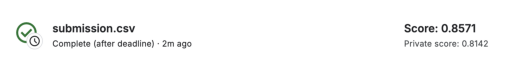

In [3]:
img = mpimg.imread('/content/Screenshot 2025-02-21 at 8.26.23 PM.png')
plt.imshow(img)
plt.axis('off')
plt.show()

## Conclusion

In conclusion, we created a convolutional neural network to evaluate various images of cells to see if they are cancerous or not. We tuned our CNN on number of layers and the learning rate to determine the optimal sequential model on the training set. Each model was then evaluated against the validation set and the loss, accuracy, and roc score was assessed. The best model was determined to be model 2 due to the highest validation loss and accuracy scores. Using that model, we created predictions against the test set and the score of those predictions was determined to be 0.8571.

Takeaways:
*   The 3 layer model with a learning rate of 0.000001 was the best model for this dataset.
*   It was difficult getting GPU run time on Google Colab, need to strategize GPU usage more in the future.

Improvements:
*   Experiment with tuning other hyperparameters like the number of epochs or batch sizes.
*   Try using other activation functions in the model.





